### Serverial questions for CNN!
1. Why LeNet use Sigmoid after a conv layer?
2. How `xavier_uniform_` works?
3. Why I add a softmax layer at the end of NN will bring vanishing to gradients?
4. Why cross entropy loss seems flatuated between epochs, but finally we could get a good predict resuts through NN.
5. If we didn't apply softmax in NN, how did the cross entropy calculation correct?

### TODO
modern CNN chapter not finished!

In [7]:
import torch
from torch import nn
from d2l import torch as d2l

In [8]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(nn.Module):
    def __init__(self,num_classes=10):
        super().__init__()
        self.net=nn.Sequential(
            nn.LazyConv2d(6,kernel_size=5,padding=2),
            nn.ReLU(),
            #nn.Sigmoid(), # why sigmod after a conv?
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.LazyConv2d(16,kernel_size=5),
            nn.ReLU(),
            #nn.Sigmoid(), # ditto?
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Flatten(), # transform into a vector tensor
            nn.LazyLinear(120), #nn.Sigmoid(),
            nn.ReLU(),
            nn.LazyLinear(84), #nn.Sigmoid(),
            nn.ReLU(),
            nn.LazyLinear(num_classes))
            #, nn.Softmax()) # A softmax layer seems bring vanishing gradient, why?
        for layer in self.net:
            init_cnn(layer)

    def forward(self, X):
        return self.net(X)

    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)



In [9]:
model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
ReLU output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [10]:
print("\nParameters before optimizer step:")
for name, param in model.named_parameters():
    print(f"{name}:\n{param}")


Parameters before optimizer step:
net.0.weight:
Parameter containing:
tensor([[[[ 0.0491,  0.0674,  0.0668, -0.1424, -0.0397],
          [-0.1287,  0.0895,  0.0596,  0.1823,  0.1213],
          [ 0.0929,  0.0267, -0.0468, -0.0829, -0.1518],
          [-0.1818, -0.1280,  0.1751,  0.0271,  0.1435],
          [ 0.1501,  0.1302, -0.1514, -0.0975,  0.1376]]],


        [[[ 0.1358,  0.1138, -0.1468, -0.1471,  0.0133],
          [-0.0355,  0.1731,  0.1750, -0.0132, -0.1439],
          [ 0.1439, -0.0341, -0.1734,  0.0259, -0.0195],
          [ 0.1808,  0.1655, -0.0647, -0.0787, -0.1858],
          [-0.1702,  0.1040, -0.0646, -0.0764,  0.1128]]],


        [[[ 0.1678, -0.0262, -0.0363, -0.0486, -0.0867],
          [ 0.0260,  0.0865,  0.0204, -0.1082, -0.0741],
          [ 0.0373,  0.1970, -0.0284,  0.0684,  0.0470],
          [-0.0513,  0.1667,  0.0055,  0.1317,  0.1229],
          [ 0.1628,  0.1142,  0.0234,  0.1148, -0.0101]]],


        [[[ 0.0755,  0.1908,  0.1451,  0.1966,  0.0406],
     

In [11]:
loss=nn.CrossEntropyLoss()
#optimizer=torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.parameters()

<generator object Module.parameters at 0x7f936fad8c10>

In [12]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [13]:
for X, y in train_iter:
    print(model(X))
    print(model(X).shape)
    break

tensor([[-0.0715, -0.1272, -0.0706,  ...,  0.0210, -0.1085, -0.0542],
        [-0.0668, -0.1256, -0.0747,  ...,  0.0186, -0.1057, -0.0465],
        [-0.0714, -0.1367, -0.0724,  ...,  0.0246, -0.1072, -0.0545],
        ...,
        [-0.0679, -0.1249, -0.0734,  ...,  0.0205, -0.1056, -0.0481],
        [-0.0729, -0.1352, -0.0699,  ...,  0.0196, -0.1034, -0.0519],
        [-0.0724, -0.1335, -0.0720,  ...,  0.0191, -0.1069, -0.0468]],
       grad_fn=<AddmmBackward0>)
torch.Size([256, 10])


In [14]:
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss=0
    for X, y in train_iter:
        y_hat=model(X)
        #print("y_hat shape: ", y_hat.shape)
        #print("y shape: ", y.shape)
        y_true=torch.zeros(y_hat.shape)
        y_true[range(len(y_hat)), y] = 1
        #print(y_true)
        ls=loss(y_hat,y_true)
        #print("\nls is:")
        #print(ls)
        
        optimizer.zero_grad()
        #print("\nGradients before backward pass:")
        #for name, param in model.named_parameters():
        #    print(f"{name} gradients:\n{param.grad}")
        #    break
        ls.backward()
        #print("\nGradients after backward pass:")
        #for name, param in model.named_parameters():
        #    print(f"{name} gradients:\n{param.grad}")
        #    break
        optimizer.step()
        

        running_loss+=ls.item()
        #break
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {ls/len(train_iter):.4f}")

Epoch [1/10], Loss: 0.0019
Epoch [2/10], Loss: 0.0008
Epoch [3/10], Loss: 0.0010
Epoch [4/10], Loss: 0.0011
Epoch [5/10], Loss: 0.0012
Epoch [6/10], Loss: 0.0015
Epoch [7/10], Loss: 0.0015
Epoch [8/10], Loss: 0.0013
Epoch [9/10], Loss: 0.0019
Epoch [10/10], Loss: 0.0010


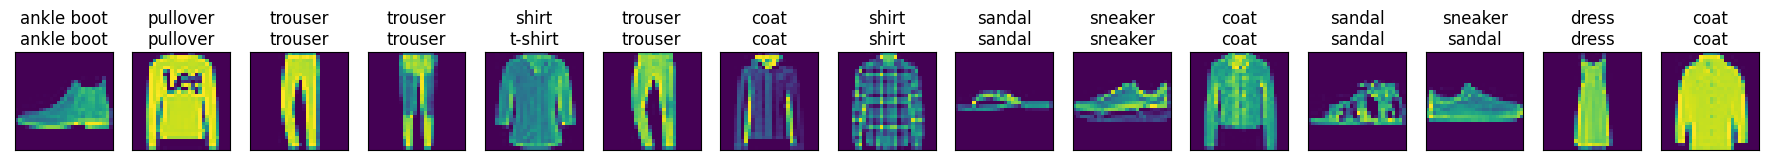

In [15]:
def predict(net, test_iter, n=15):  #@save
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(model(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict(model, test_iter)

In [16]:
torch.save(model, 'LeNet.pth')

In [19]:
torch.onnx.export(model, X, "LeNet.onnx")